In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as s

In [2]:
from sklearn.linear_model import LinearRegression

def linRegressionAddInsideTemperature(df):
    linReg = LinearRegression()
    x = df[['T-outside','H-outside','T-inside']]
    noNan = x[x['T-inside'].notnull()].drop(columns='T-inside')
    noNanTinside = x[x['T-inside'].notnull()]['T-inside']
    linReg.fit(noNan,noNanTinside)
    nanT = x[x['T-inside'].isnull()].drop(columns='T-inside')
    result = linReg.predict(nanT)
    df['T-inside'][df['T-inside'].isnull()] = result
    return df

def linRegressionAddInsideHumidity(df):
    linReg = LinearRegression()
    x = df[['T-outside','H-outside','H-inside']]
    noNan = x[x['H-inside'].notnull()].drop(columns='H-inside')
    noNanTinside = x[x['H-inside'].notnull()]['H-inside']
    linReg.fit(noNan,noNanTinside)
    nanT = x[x['H-inside'].isnull()].drop(columns='H-inside')
    result = linReg.predict(nanT)
    df['H-inside'][df['H-inside'].isnull()] = result
    return df

In [3]:
def loadDataset(resampleParam):
    #load temperature and humidity data from outside
    outDf = pd.read_csv("./data/data.csv", delimiter = ";")
    outDf = outDf.rename(columns={'Tim': "Time", "Temperature": "T-outside", "Humidity": "H-outside"})
    outDf.index = pd.to_datetime(outDf['Time'], format='%d.%m.%Y %H:%M:%S' )
    outDf = outDf.drop(columns=['Time'])
    
    #load consumption data 
    consumptionDf = pd.read_csv("./data/spotreba.csv",delimiter = ";")
    consumptionDf = consumptionDf.rename(columns={'Tim': "Time", "delta kWh": "KWH"})
    consumptionDf.index = pd.to_datetime(consumptionDf['Time'], format='%d.%m.%Y %H:%M' )
    consumptionDf = consumptionDf.drop(columns=['Time'])
    
    #load temperature nad humidity data from inside
    inDf = pd.read_csv("./data/serverovna.csv",delimiter = ";")
    inDf = inDf.rename(columns={'Tim': "Time", "Temperature": "T-inside", "Humidity": "H-inside"})
    inDf.index = pd.to_datetime(inDf['Time'], format='%d.%m.%Y %H:%M:%S' )
    inDf = inDf.drop(columns=['Time'])
    
    #resample all data by input parameter
    outDfResampled = outDf.resample(resampleParam).mean()
    consumptionDfResampled = consumptionDf.resample(resampleParam).sum()
    inDfResampled = inDf.resample(resampleParam).mean()
    
    #join data
    df = outDfResampled.join(consumptionDfResampled,how="inner")
    df = df.dropna()
    df = df.join(inDfResampled,how="left")
    
    #fill nan from inside measurement by linear regression
    df = linRegressionAddInsideTemperature(df)
    df = linRegressionAddInsideHumidity(df)
       
    return df

In [4]:
df = loadDataset('H')

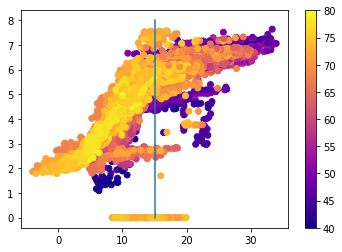

In [5]:
plt.scatter(df['T-outside'],df['KWH'], c=df['H-outside'],cmap='plasma')
plt.plot([15,15],[0,8])
plt.colorbar()
plt.show()

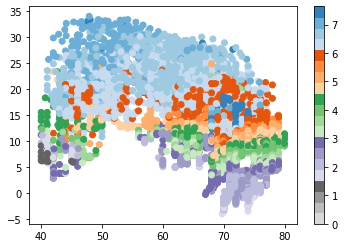

In [6]:
plt.scatter(df['H-outside'],df['T-outside'], c=df['KWH'],cmap='tab20c_r')
plt.colorbar()

C:\Users\William.Brach\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


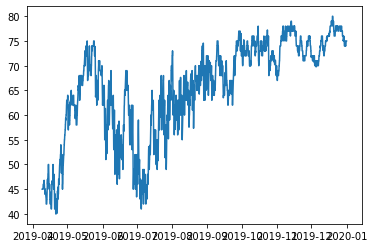

In [7]:
plt.plot(df['H-outside'])

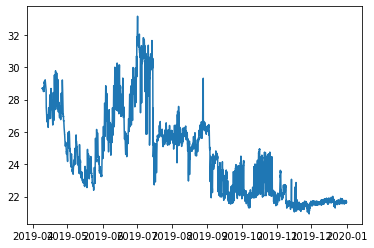

In [8]:
plt.plot(df['T-inside'])

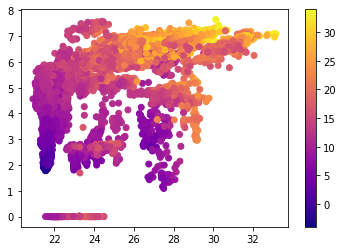

In [9]:
plt.scatter(df['T-inside'],df['KWH'], c=df['T-outside'],cmap='plasma')
plt.colorbar()
plt.show()